# Caso StudioSAS - Prueba Resolve
### Cargo: Científico de datos
### Angie Navarrete Soto

____________

#### Lectura y análisis preliminar de los datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import SVG
import graphviz 
from sklearn.tree import export_graphviz
import pydot
import pylab as pl
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
users = pd.read_csv('../Users.csv')
events = pd.read_csv('../Events.csv')

In [3]:
users.head()

,clientID,Date,Minute,Keyword,Country_Code,sourceMedium,Event_Name,Device_Category,Hour,Channel,Carrier,WIFI,Operator
0,5883363385-29485069892872A27982617515855L91K83942,2020-04-02 22:09:40 UTC,9,NaN,CO,organic,install,phone,22,NaN,ETB 4G,True,ETB 4G
1,5877639398-61841728799082A27982617515855L91K21770,2020-04-02 20:34:11 UTC,34,NaN,CO,Facebook Ads,install,phone,20,Facebook,ETB 4G,False,ETB 4G
2,5876447535-51889087691502A27982617515855L91K92444,2020-04-02 20:14:12 UTC,14,NaN,CO,organic,install,phone,20,NaN,Movistar,True,"""#QuedateEnCasa"""
3,5881617354-75650607331532A27982617515855L91K40...,2020-04-02 21:40:20 UTC,40,NaN,CO,organic,install,phone,21,NaN,Movistar,False,Movistar
4,5882068190-14016981306802A27982617515855L91K87...,2020-04-02 21:47:53 UTC,47,NaN,CO,organic,install,phone,21,NaN,Movistar,False,Movistar


In [4]:
events.head()

,start_date,end_date,event_name
0,2020-03-29 18:10:03 UTC,2020-03-29 18:10:18 UTC,A
1,2020-03-28 18:19:12 UTC,2020-03-28 18:19:27 UTC,A
2,2020-03-28 23:52:30 UTC,2020-03-28 23:52:45 UTC,A
3,2020-03-29 22:32:41 UTC,2020-03-29 22:32:56 UTC,A
4,2020-03-22 20:51:28 UTC,2020-03-22 20:51:43 UTC,A


In [5]:
users.describe(include=[np.object,np.int, np.bool])

,clientID,Date,Minute,Country_Code,sourceMedium,Event_Name,Device_Category,Hour,Channel,Carrier,WIFI,Operator
count,660694,660694,660694.000000,660694,660399,660694,560349,660694.000000,182694,402516,660694,409579
unique,592953,437350,NaN,1,52,2,3,NaN,52,308,2,301
top,2405497670-67774876303982A27982617515825L91K96...,2020-04-01 23:41:31 UTC,NaN,CO,organic,install,phone,NaN,Facebook,Claro,True,Claro
freq,35,21,NaN,660694,433297,560373,555900,NaN,91676,160695,444133,169243
mean,NaN,NaN,29.952816,NaN,NaN,NaN,NaN,15.559195,NaN,NaN,NaN,NaN
std,NaN,NaN,17.147082,NaN,NaN,NaN,NaN,4.615769,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,15.000000,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,31.000000,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,44.000000,NaN,NaN,NaN,NaN,19.000000,NaN,NaN,NaN,NaN


In [6]:
events.describe()

,start_date,end_date,event_name
count,258,258,258
unique,258,258,14
top,2020-03-30 10:59:45 UTC,2020-03-22 17:32:51 UTC,B
freq,1,1,43


Valores faltantes para cada variable en la base *users*

In [7]:
users.isna().sum()

clientID                0
Date                    0
Minute                  0
Keyword            660694
Country_Code            0
sourceMedium          295
Event_Name              0
Device_Category    100345
Hour                    0
Channel            478000
Carrier            258178
WIFI                    0
Operator           251115
dtype: int64

A primera vista se evidencia que hay dos variables que no entregan valor, Country_Code por ser una constante y Keyword por ser una variable vacía. Las variables sourceMedium, Channel, Carrier y Operator tienen un gran número de posibles valores (hasta 300) lo cual dificulta el análisis y dada la poca correlación que suelen tener, llegan a deteriorar el nivel de los modelos.

Hay gran cantidad de valores faltantes, pero como se encuentran en diferentes variables y en diferente medida o cantidad, se dejarán para hacer el análisis, pues no se quieren perder muchos datos para entrenar el modelo.

Dado que el problema habla de "eventos" como el interés del proyecto, se tomará la variable *Event_Name* como la variable a clasificar, los valores que toma son:

- install 
- FIRST_ORDER_PLACED_CONFIRMED_BACK 

Por facilidad y por un mejor manejo de los datos se categorizará la variable como dummie como sigue

- install : 1
- FIRST_ORDER_PLACED_CONFIRMED_BACK :0

In [8]:
users_dummie = pd.get_dummies(users,columns=['Event_Name'], drop_first = True)

Como preliminarmente no se encuentra relación entre las tablas *users* y *events*, (por tipo de evento) se hará un cruce por fechas/horas de los eventos a ver si hay relación entre las dos tablas

In [9]:
merge = pd.merge(users_dummie,events,how='inner', left_on ='Date', right_on='start_date')

In [10]:
merge.isna().sum()

clientID                0
Date                    0
Minute                  0
Keyword               206
Country_Code            0
sourceMedium            0
Device_Category        39
Hour                    0
Channel               158
Carrier                86
WIFI                    0
Operator               83
Event_Name_install      0
start_date              0
end_date                0
event_name              0
dtype: int64

Hay 206 registros que coinciden de las tablas *users* y *eventos*, estos son los registros que podemos asociar a un evento de **instalación** o **primera orden**, y a la vez dentro de las categorías **A**, **AA**, **B**, ..., **Y**,**Z**. 

Para el modelo se seguirá con la información de la tabla *users* y el tipo de evento que a esta le corresponde, pues los eventos asociados a la tabla *events* tiene muy pocos datos asociados y no merecería la pena desperdiciar la infromación brindada por la tabla *users*

**Nota**: en el dashboard se podrá ver la relación y frecuencia de eventos que hay entre ambas tablas y cada una por separado.

### Análisis exploratorio

Los gráficos del análisis exploratorio se pueden visualizar en el dash y lo utilicé como apoyo a lo largo de la toma de desiciones de este notebook. Se mencionarán ocasionalmente en este documento

Las frecuencias de cada una de las variables que se visuliza en el dash, nos da información de que la mayoría de las personas que se registran en los datos, cuentan con Celular, tienen acceso a WiFi, son atendidas en las horas de la tarde y en su mayoría requieren instalación.

Por otro lado, para las variables sourceMedium, Channel, Carrier, Operator para las que solo se visulizan las opciones más frecuentadas (top 10), se puede ver que tanto para Carrier como Operator las categorías y sus frecuencias son casi las mismas, lo cual puede representar una similitud entre las variables que lleve a que sea casi como una variable repetida que no agregue valor.

In [11]:
pd.crosstab(index=users['Event_Name'],
            columns=users['Operator'], margins=True)

Operator,"""""""Telecom NZ""""""","""#MiSeleccion""","""#QuedateEnCasa""","""Avantel Roaming ""","""DIGITEL ""","""TIGO ""","""TIGO 4G """,+Movil,019,1&1,...,vodafone ES,vodafone IE,vodafone IT,vodafone MT,weex,zain JO,zte,中国移动,空白,All
Event_Name,,,,,,,,,,,,,,,,,,,,,
install,1,53,34808,1,1,3,450,11,1,4,...,5,1,3,5,2,1,1,1,7,409579
All,1,53,34808,1,1,3,450,11,1,4,...,5,1,3,5,2,1,1,1,7,409579


De la tabla anterior y del dash se puede ver que **Operator** y **Carrier** solo tienen valores para el evento 'instalación'. Es decir que los valores faltantes están en los registros donde el evento hace referencia a Primera Orden. Seguramente es una variable que solo se registra cuando se hace una instalación, por lo cual no se atribuye a un posible evento, sino a un evento ya sucedido.

## Modelo de clasificación

Debido a la falta de claridad en los eventos, se hará el análisis en base a la variable *Event_Name* de la tabla *Users*, y esta se tomará como variable de clasificación. 
Para escoger el método de clasificación hay que tener en cuenta que la mayoría, por no decir todas, primero se realizará un análisis de correlación para la decisión de selección de variables y luego se seguirá a entrenar el modelo

In [12]:
users_dummie['Event_Name_install'].value_counts() #Cantidad de usuarios por evento

1    560373
0    100321
Name: Event_Name_install, dtype: int64

Se categorizará la varibale *Device_Category* para ver cómo se correlaciona con la variable del evento.

In [13]:
users_dummie = pd.get_dummies(users_dummie,columns=['Device_Category'])

In [14]:
users_dummie.corr()

,Minute,Keyword,Hour,WIFI,Event_Name_install,Device_Category_other,Device_Category_phone,Device_Category_tablet
Minute,1.000000,NaN,-0.001002,-0.030581,-0.051290,-0.001092,-0.050183,-0.000989
Keyword,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hour,-0.001002,NaN,1.000000,-0.076141,-0.146479,-0.000071,-0.140349,-0.015896
WIFI,-0.030581,NaN,-0.076141,1.000000,0.605932,0.003842,0.583931,0.050292
Event_Name_install,-0.051290,NaN,-0.146479,0.605932,1.000000,0.002328,0.974513,0.034759
Device_Category_other,-0.001092,NaN,-0.000071,0.003842,0.002328,1.000000,-0.012672,-0.000452
Device_Category_phone,-0.050183,NaN,-0.140349,0.583931,0.974513,-0.012672,1.000000,-0.189210
Device_Category_tablet,-0.000989,NaN,-0.015896,0.050292,0.034759,-0.000452,-0.189210,1.000000


Se puede ver que solo la categoría Device_Category_phone tiene alta correlación con Event_Name_install, y por tanto se tomará unicamente esta variable en el modelo.

Ahora veamos qué pasa con esas variables que tienen más de 50 categorías posibles.

In [15]:
users_dummie1 = pd.get_dummies(users_dummie,columns=['sourceMedium'])

In [16]:
users_dummie1.corr()

,Minute,Keyword,Hour,WIFI,Event_Name_install,Device_Category_other,Device_Category_phone,Device_Category_tablet,sourceMedium_Apple Search Ads,sourceMedium_Emails,...,sourceMedium_rankmyapp_int,sourceMedium_siftco_int,sourceMedium_sitescout_int,sourceMedium_smadex_int,sourceMedium_snapchat_int,sourceMedium_stroermobileagency,sourceMedium_tapjoy_int,sourceMedium_yahoogemini_int,sourceMedium_ydigital_int,sourceMedium_youappi
Minute,1.000000,NaN,-0.001002,-0.030581,-0.051290,-0.001092,-0.050183,-0.000989,0.001366,0.000847,...,0.000496,0.001324,-0.000929,-0.000637,0.002010,0.000916,0.001510,0.000653,-0.002148,0.000793
Keyword,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hour,-0.001002,NaN,1.000000,-0.076141,-0.146479,-0.000071,-0.140349,-0.015896,-0.054369,-0.002589,...,0.004279,0.002805,-0.000149,0.001847,0.002509,0.000832,-0.004147,-0.002541,0.000357,-0.000949
WIFI,-0.030581,NaN,-0.076141,1.000000,0.605932,0.003842,0.583931,0.050292,-0.005224,0.002430,...,-0.020774,-0.002492,-0.001762,-0.016533,-0.007475,-0.004316,-0.001762,-0.003246,-0.003052,-0.001762
Event_Name_install,-0.051290,NaN,-0.146479,0.605932,1.000000,0.002328,0.974513,0.034759,-0.015142,0.001472,...,-0.034284,-0.004112,-0.002908,-0.027380,-0.012336,-0.007122,-0.002908,-0.005723,-0.005036,-0.002908
Device_Category_other,-0.001092,NaN,-0.000071,0.003842,0.002328,1.000000,-0.012672,-0.000452,-0.000638,-0.000019,...,-0.000080,-0.000010,-0.000007,-0.000065,-0.000029,-0.000017,-0.000007,-0.000017,-0.000012,-0.000007
Device_Category_phone,-0.050183,NaN,-0.140349,0.583931,0.974513,-0.012672,1.000000,-0.189210,-0.018555,0.001511,...,-0.033411,-0.004007,-0.002834,-0.026679,-0.012022,-0.006941,-0.002834,-0.005566,-0.004908,-0.002834
Device_Category_tablet,-0.000989,NaN,-0.015896,0.050292,0.034759,-0.000452,-0.189210,1.000000,0.016571,-0.000286,...,-0.001192,-0.000143,-0.000101,-0.000964,-0.000429,-0.000248,-0.000101,-0.000248,-0.000175,-0.000101
sourceMedium_Apple Search Ads,0.001366,NaN,-0.054369,-0.005224,-0.015142,-0.000638,-0.018555,0.016571,1.000000,-0.000404,...,-0.001682,-0.000202,-0.000143,-0.001361,-0.000605,-0.000349,-0.000143,-0.000349,-0.000247,-0.000143
sourceMedium_Emails,0.000847,NaN,-0.002589,0.002430,0.001472,-0.000019,0.001511,-0.000286,-0.000404,1.000000,...,-0.000050,-0.000006,-0.000004,-0.000041,-0.000018,-0.000010,-0.000004,-0.000010,-0.000007,-0.000004


A ojo, es evidente que NINGUNA de las categorías de sourceMedium tiene correlación mayor al 1% con el evento, esto es algo que "siempre" pasa en variables con tantas categorías. A menos que de las posibles 300 categorías, haya dos o tres que representen la gran mayoría de datos, no suelen aportar casi nada a que un evento suceda o no y si se llevan un alto procesamiento en los modelos. En este caso, ni siquiera la categoróa *organic* que es la que más frecuencia (como se puede ver en el **dash**) representa una alta correlación.

Por todo lo anterior se tomarán las variables **Hour**, **WIFI**, **Device_Category_phone** para entrenar el modelo. Son pocas variables, y de ser posible pediría más al cliente, sin embargo de la infromación que se tiene, es lo único que está afectando en el acontecimiento de los eventos. Por esto, no tendría mayor sentido entrenar modelos a las malas esperando obtener buenos resultados.

In [17]:
X = users_dummie[['Hour','WIFI','Device_Category_phone']]
y = users_dummie['Event_Name_install']

Se dividirán los datos de entrenamiento y test en una relación de 80/20, como usualmente se hace. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020)

In [19]:
print('Número de muestras en entrenamiento: {}'.format(X_train.shape[0]))
print('Número de muestras en prueba: {}'.format(X_test.shape[0]))
print('Número de características: {}'.format(X_train.shape[1]))

print('Distribución de clases en entrenamiento: {}'.format(np.bincount(y_train)))
print('Distribución de clases en prueba: {}'.format(np.bincount(y_test)))

Número de muestras en entrenamiento: 528555
Número de muestras en prueba: 132139
Número de características: 3
Distribución de clases en entrenamiento: [ 80492 448063]
Distribución de clases en prueba: [ 19829 112310]


In [20]:
#80492/448063
round(19829/112310,3)

0.177

Es importante ver la distribución de la variable a clasfiicar en ambos conjuntos (train/test), en este caso, para ambos conjuntos quedó aproximadamente el 17% de datos con evento de *primera orden*, y el restante para *instalación*, por lo cual la división de datos quedó equilibrada y se puede seguir

Primero se intetará con un árbol de decisión dado el tipo de variables que se tienen para explicar el evento (categóricas), y también porque suele ser un clasificador con muy buenos resultados. De no resultar buenos resultados, se podría seguir con un clasificador KNN o un SVM. También se puede considerar un random forest regún el comportamiento del árbol de desición

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
classifier = DecisionTreeClassifier(max_depth = 4)

Se intentará con una profunidad inicial de 4 (Ni tan grande, ni tan peuqeño), es decir cuatro capas para la toma de desición del árbol. Tambien se toma este número para poder visualmente las decisiones que toma.

In [23]:
%%time
classifier = classifier.fit(X, y)

CPU times: user 156 ms, sys: 19.9 ms, total: 176 ms
Wall time: 245 ms


El tiempo de ejecución en los árboles de desición son menores en muchos casos en comparación a otros clasificadores, tomó solamente 153ml en entrenar el modelo.
En el siguiente gráfico se puede ver el árbol de decisión como tal y los caminos que toma para llegar a la clasificación final 

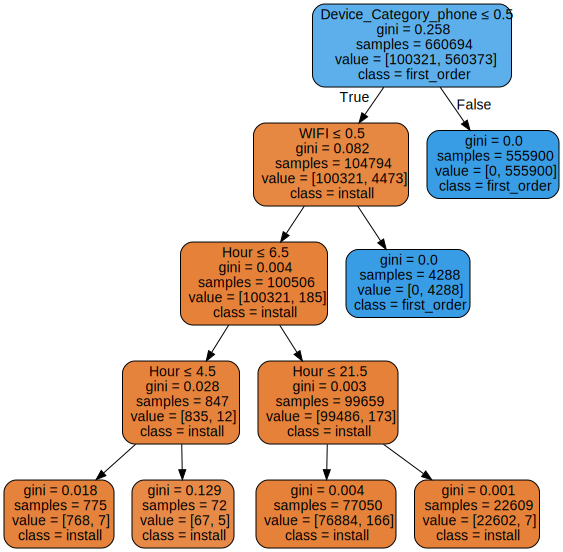

In [24]:
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=['Hour','WIFI','Device_Category_phone'],  
                         class_names=['install','first_order'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

In [25]:
classifier.feature_importances_

array([5.06132881e-06, 4.82594894e-02, 9.51735449e-01])

Se observa que el peso casi completo de las variables en el modelo es *Device_Category_phone*, esto no es muy bueno porque esto se debe a que los registros existentes a esta categoría se da cuando el evento es únicamente de instalación, sin embargo se vio necesario incluirla dadas las pocas variables que se podían rescatar de la base orgiinal

In [26]:
print('Error en entrenamiento: {}'.format(1-classifier.score(X_train, y_train)))
print('Error de generalización: {}'.format(1 - classifier.score(X_test, y_test)))

Error en entrenamiento: 0.00029136040714783373
Error de generalización: 0.00023460144242049008


Los errores son muy pequeños, lo que quiere decir que el modelo tiene un muy buen ajuste. Ahora haremos la clasficación de el conjunto de datos de test y veremos algunas métricas para asegurarnos que el modelo sea lo suficientemente bueno

In [27]:
y_pred = classifier.predict(X_test)

In [28]:

print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, pos_label=0 )))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred,  pos_label=0)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_pred,  pos_label=0)))

Precision: 0.9984390735146023
Recall: 1.0
F_1 score: 0.9992189271586586


Las métricas indica un muy bue ajuste en el modelo. El Recall nos dice que todos los verdaderos positivos se clasificaron bien, es decir que todos los que eran instalación en realidad, fueron clasificados como tal, y eso lo podemos ver también en la matríz de confusión, recordemos que 0: 'Primera orden', 1: 'Instalación' (este es el orden de las entradas en la matriz)

In [29]:
confusion_matrix(y_test, y_pred)

array([[ 19829,      0],
       [    31, 112279]])

Si quisiera optimizar los hiperparámetros del modelo podríamos hacer un grid_search, en este casi es sencillo pues el hiperparámetro para este modelo comñunmente modificado es la profundidad del árbol, es decir cuántos "pisos" usa para tomar la desición

In [30]:
train_error = []
generalization_error = []
max_depth_values = list(range(1, 21, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

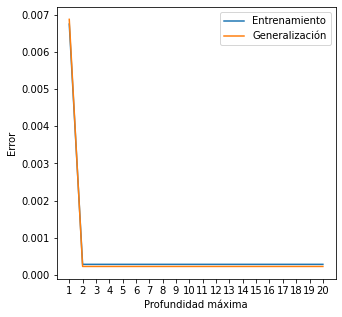

In [31]:
pl.figure(figsize = (5, 5))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.legend();

Se observa que con dos grados de profunidad habría sido necesario para entrenar el modelo, pues en 2 se estabiliza el error y no es necesario agregar más capas de profundidad

## Limitaciones

Como primera medida, pediría al cliente más información sobre los eventos para tener más claridad del problema. La información entre tablas no tiene un cruce muy consecuente, y las variables de eventos no representan un problema claro.

Referente al modelo:
Dada la cantidad de variables categóricas y especialmente la cantidad de categorías al interior de cada una, se terminan eliminando muchas variables dado que no aportan información valiosa a la clasificación, de ser posible pedir algunas variables extra que puedan llegar a tener más correlación con los eventos para incluír en el modelo.

## Escenario de producción

Una vez el proyecto llegue a ser un MVP y se piense en desplegar en un servidor por temas de seguridad, escalabilidad, uso del cliente (accesibilidad), etc. se recomienda montar a un servidor en la nube.
El servidor depende en gran medida del volúmen de los datos que se deben almacenar y de las características que se requieran en la plataforma. Para un producto con estas caracterísitcas, que no tiene un volúmen alto de datos y si se quiere ahorrar en costos se puede recurrir a un PaaS como Heroku. Sin emabrgo, si el producto se proyecta a tener caracterísiticas más demandantes se puede pensar en recurrir un servidor más potente como AWS, GCP o Azure, dependiendo de los entornos de trabajo, el almacenamiento y arquitectura de los datos, costos, llegada de nuevos datos, entre otras cosas.